In [1]:
%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler




In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


d:\master3\Master-thesis\Files\func.py:23: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [4]:
target_days = 10

return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift)

In [5]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [6]:
# load all models
%reload_ext autoreload
%autoreload 2
"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
xgb_best = pickle.load(open('xgb_model.pickle', 'rb'))"""
NN_model, history, X_test_scaled = train_and_evaluate_NN(X_train_eval, y_train_eval, X_eval, y_eval, X_test, y_test)

param_grid_alpha = {'alpha': 10.0}
ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha)

param_grid_xgb =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

xgb_best, best_params = optimize_and_train_xgb(X_train, y_train, X_eval, y_eval, param_grid_xgb)

param_grid_lgb =  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}

lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb)



C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 7s 705us/step - accuracy: 0.5101 - loss: 0.2501 - val_accuracy: 0.5353 - val_loss: 0.2485
Epoch 2/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 653us/step - accuracy: 0.5296 - loss: 0.2488 - val_accuracy: 0.5364 - val_loss: 0.2480
Epoch 3/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 667us/step - accuracy: 0.5360 - loss: 0.2479 - val_accuracy: 0.5489 - val_loss: 0.2464
Epoch 4/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 654us/step - accuracy: 0.5429 - loss: 0.2470 - val_accuracy: 0.5528 - val_loss: 0.2456
Epoch 5/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 4s 653us/step - accuracy: 0.5508 - loss: 0.2460 - val_accuracy: 0.5546 - val_loss: 0.2449
Restoring model weights from the end of the best epoch: 5.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > nu

In [7]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "XGBoost Classifier": xgb_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 2s 402us/step
Ridge Classifier:
Accuracy: 0.5155106630994624
Confusion Matrix:
[[78919 20353]
 [73995 21470]]
Precision: 51.335389618152696
Recall: 22.489917770910807
F1 Score: 31.277314841792435
MSE: 48.448933690053764
RMSE: 69.60526825611245


XGBoost Classifier:
Accuracy: 0.5136363402948593
Confusion Matrix:
[[52887 46385]
 [48328 47137]]
Precision: 50.40204443874169
Recall: 49.3762111768711
F1 Score: 49.883854445014734
MSE: 48.63636597051408
RMSE: 69.73977772441928


LightGBM Classifier:
Accuracy: 0.5177906612508152
Confusion Matrix:
[[55333 43939]
 [49965 45500]]
Precision: 50.872661814197386
Recall: 47.66144660346724
F1 Score: 49.2147276424523
MSE: 48.22093387491848
RMSE: 69.44129454072589


Neural Network:
Accuracy: 0.5125014763501543
Confusion Matrix:
[[62263 37009]
 [57925 37540]]
Precision: 50.3561415981435
Recall: 39

In [8]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [9]:
results_best = {}
results_worst = {}
models = {
    'lgb': lgb_best,
    'xgb': xgb_best,
    'ridge': ridge_best,
    'NN': NN_model,
    'benchmark': None
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy(),
    'benchmark': df_2_neutral.copy()
}


In [10]:
%reload_ext autoreload
%autoreload 2

signals_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy(),
    'benchmark': df_2_neutral.copy()
}

portfolio_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy(),
    'benchmark': df_2_neutral.copy()
}

for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name, df_read, date_col) 
    assets_df = pd.concat([best_assets, worst_assets])
    assets_df['update_value'] = 0
    assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
    assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

    pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
    signals_dfs[name].update(pivot_df)

    portfolio_dfs[name] = update_df_with_asset_performance(signals_dfs[name], portfolio_dfs[name], target_days, df_read)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 2s 403us/step


In [11]:
xgb_weights = portfolio_dfs['xgb']
lgb_weights = portfolio_dfs['lgb']
ridge_weights = portfolio_dfs['ridge']
NN_weights = portfolio_dfs['NN']
benchmark_weights = portfolio_dfs['benchmark']




xgb_returns = xgb_weights*df_2_read
lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read
benchmark_returns = benchmark_weights*df_2_read


"""xgb_trade_volume = calculate_trade_volume(xgb_weights)
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)"""

'xgb_trade_volume = calculate_trade_volume(xgb_weights)\nlgb_trade_volume = calculate_trade_volume(lgb_weights)\nridge_trade_volume = calculate_trade_volume(ridge_weights)\nNN_trade_volume = calculate_trade_volume(NN_weights)'

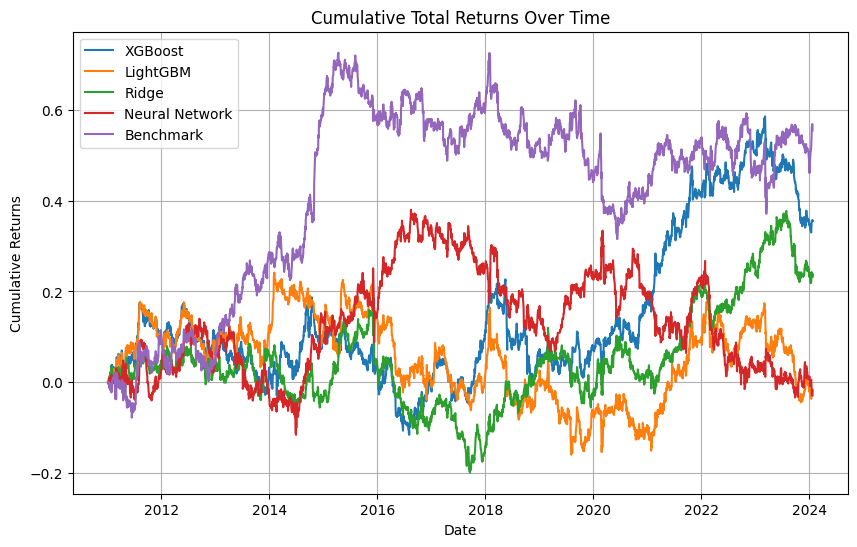

In [12]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
xgb_total_returns = xgb_returns.sum(axis=1)
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)
benchmark_total_returns = benchmark_returns.sum(axis=1)
# Calculate the cumulative total returns for each model
#xgb_cumulative_total_returns = (1 + xgb_total_returns).cumprod() - 1
#lgb_cumulative_total_returns = (1 + lgb_total_returns).cumprod() - 1
#ridge_cumulative_total_returns = (1 + ridge_total_returns).cumprod() - 1
#NN_cumulative_total_returns = (1 + NN_total_returns).cumprod() - 1

# use cumsum 
xgb_cumulative_total_returns = xgb_total_returns.cumsum()
lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()
NN_cumulative_total_returns = NN_total_returns.cumsum()
benchmark_cumulative_total_returns = benchmark_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(xgb_cumulative_total_returns, label='XGBoost')
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.plot(benchmark_cumulative_total_returns, label='Benchmark')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [14]:

ridge_metrics = financial_metrics(ridge_total_returns, ridge_weights)
lgb_metrics = financial_metrics(lgb_total_returns, lgb_weights)
xgb_metrics = financial_metrics(xgb_total_returns, xgb_weights)
NN_metrics = financial_metrics(NN_total_returns,NN_weights )
benchmark_metrics = financial_metrics(benchmark_total_returns, benchmark_weights)
metrics = {
    "Ridge": ridge_metrics,
    "LightGBM": lgb_metrics,
    "XGBoost": xgb_metrics,
    "Neural Network": NN_metrics,
    "Benchmark": benchmark_metrics
}

metrics_df = pd.DataFrame(metrics).T  


In [15]:
metrics_df

,Average Yearly Return,Average Yearly Standard Deviation,Sharpe Ratio,Max Drawdown,Volatility,Calmar Ratio,Skewness,Kurtosis,Trades
Ridge,0.017387,0.108655,0.160018,-2.483780,0.108655,0.007000,-0.165429,2.979363,6839.0
LightGBM,-0.001228,0.121544,-0.010106,-1.811819,0.121544,-0.000678,-0.152269,5.223286,6378.0
XGBoost,0.026666,0.119406,0.223324,-1.760707,0.119406,0.015145,-0.486062,5.490936,6399.0
Neural Network,-0.001479,0.133314,-0.011094,-2.692084,0.133314,-0.000549,-0.024531,12.729091,6543.0
Benchmark,0.041635,0.136252,0.305574,-39.554276,0.136252,0.001053,-0.626918,7.940721,5221.0


In [ ]:
metrics_df

,Average Yearly Return,Average Yearly Standard Deviation,Sharpe Ratio,Max Drawdown,Volatility,Calmar Ratio,Skewness,Kurtosis,Trades
Ridge,0.017387,0.108655,0.160018,-2.483780,0.108655,0.007000,-0.165429,2.979363,6839.0
LightGBM,-0.001228,0.121544,-0.010106,-1.811819,0.121544,-0.000678,-0.152269,5.223286,6378.0
XGBoost,0.026666,0.119406,0.223324,-1.760707,0.119406,0.015145,-0.486062,5.490936,6399.0
Neural Network,-0.001479,0.133314,-0.011094,-2.692084,0.133314,-0.000549,-0.024531,12.729091,6543.0
Benchmark,0.041635,0.136252,0.305574,-39.554276,0.136252,0.001053,-0.626918,7.940721,5221.0


In [ ]:
"""df_ranks = add_features(df_read, [63, 126, 252])

#only keep columns with "momentum"
X_ranked = df_ranks.filter(regex='momentum')

X_ranked_trans = transform_and_pivot_df(X_ranked, date_col)

columns_to_rank = X_ranked_trans.filter(regex='momentum').columns

for col in columns_to_rank:
    X_ranked_trans[col + '_rank'] = X_ranked_trans[col].rank(method='average')

# Calculate the mean of ranks across specified columns
rank_columns = [col + '_rank' for col in columns_to_rank]
X_ranked_trans['mean_rank'] = X_ranked_trans[rank_columns].mean(axis=1)

# Merge the rank data with additional data such as 'asset' and 'todate'
a = X_ranked_trans.index
b = df_ranks.index.intersection(a)
c = df_ranks.loc[b, ['asset', 'todate']]
d = X_ranked_trans[['mean_rank']].join(c)

# Calculate the top and bottom percentiles for the mean rank
e_top = d.groupby('todate')['mean_rank'].apply(lambda x: np.percentile(x, 0.9))
e_bottom = d.groupby('todate')['mean_rank'].apply(lambda x: np.percentile(x, 0.1))

# Convert to DataFrame and merge thresholds back with the ranked data
e_top_df = e_top.reset_index()
e_top_df.columns = ['todate', 'top_threshold']
e_bottom_df = e_bottom.reset_index()
e_bottom_df.columns = ['todate', 'bottom_threshold']

d_merged = d.merge(e_top_df, on='todate').merge(e_bottom_df, on='todate')

# Select top and bottom assets based on thresholds
top_assets = d_merged[d_merged['mean_rank'] >= d_merged['top_threshold']]
bottom_assets = d_merged[d_merged['mean_rank'] <= d_merged['bottom_threshold']]"""

'df_ranks = add_features(df_read, [63, 126, 252])\n\n#only keep columns with "momentum"\nX_ranked = df_ranks.filter(regex=\'momentum\')\n\nX_ranked_trans = transform_and_pivot_df(X_ranked, date_col)\n\ncolumns_to_rank = X_ranked_trans.filter(regex=\'momentum\').columns\n\nfor col in columns_to_rank:\n    X_ranked_trans[col + \'_rank\'] = X_ranked_trans[col].rank(method=\'average\')\n\n# Calculate the mean of ranks across specified columns\nrank_columns = [col + \'_rank\' for col in columns_to_rank]\nX_ranked_trans[\'mean_rank\'] = X_ranked_trans[rank_columns].mean(axis=1)\n\n# Merge the rank data with additional data such as \'asset\' and \'todate\'\na = X_ranked_trans.index\nb = df_ranks.index.intersection(a)\nc = df_ranks.loc[b, [\'asset\', \'todate\']]\nd = X_ranked_trans[[\'mean_rank\']].join(c)\n\n# Calculate the top and bottom percentiles for the mean rank\ne_top = d.groupby(\'todate\')[\'mean_rank\'].apply(lambda x: np.percentile(x, 0.9))\ne_bottom = d.groupby(\'todate\')[\'mean

In [ ]:
"""import pandas as pd
import numpy as np

df_ranks = add_features(df_read, [63, 126, 252])

#only keep columns with "momentum"
X_ranked = df_ranks.filter(regex='momentum')

X_ranked_trans = transform_and_pivot_df(X_ranked, date_col)
columns_to_rank = X_ranked_trans.filter(regex='momentum').columns

for col in columns_to_rank:
    X_ranked_trans[col + '_rank'] = X_ranked_trans[col].rank(method='average')"""

In [ ]:
"""# gruop by date 
#X_ranked_trans['mean_rank'] = X_ranked_trans[columns_to_rank + '_rank'].mean(axis=1)

rank_columns = [col + '_rank' for col in columns_to_rank]
X_ranked_trans['mean_rank'] = X_ranked_trans[rank_columns].mean(axis=1)"""

In [ ]:
"""e_top_10 = X_ranked_trans.groupby('todate')['mean_rank'].apply(lambda x: np.percentile(x, 90))
e_bottom_10 = X_ranked_trans.groupby('todate')['mean_rank'].apply(lambda x: np.percentile(x, 10))"""

In [ ]:
"""e_top_10_df = e_top_10.reset_index()
e_top_10_df.columns = ['todate', 'top_threshold']
e_bottom_10_df = e_bottom_10.reset_index()
e_bottom_10_df.columns = ['todate', 'bottom_threshold']

d_merged = X_ranked_trans.merge(e_top_10_df, on='todate').merge(e_bottom_10_df, on='todate')"""

In [ ]:
"""# Select top and bottom assets
top_assets = d_merged[d_merged['mean_rank'] >= d_merged['top_threshold']]
bottom_assets = d_merged[d_merged['mean_rank'] <= d_merged['bottom_threshold']]"""

In [ ]:
"""bench_signal = df_2_neutral.copy()

assets_df = pd.concat([top_assets, bottom_assets])
assets_df['update_value'] = 0
assets_df.loc[assets_df['mean_rank'] > assets_df['top_threshold'], 'update_value'] = 1
assets_df.loc[assets_df['mean_rank'] < assets_df['bottom_threshold'], 'update_value'] = -1

pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
bench_signal.update(pivot_df)"""

In [ ]:
"""bench_signal.tail(1)"""

,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-24,0.0,1.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.077863,-0.004837,0.009681,0.004011,0.00048,0.032585,0.029895,-0.018139,0.023889
